import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [1]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [23]:
player_df = pd.read_csv("data/player_gdf.csv", index_col=0)
player_gdf = gpd.read_file("data/player_gdf.geojson")[['fullName', 'geometry']]

In [25]:
n_am_gdf = gpd.read_file("data/Political_Boundaries_(Area)/Political_Boundaries_(Area).shp")

## Data Engineering

In [26]:
# making the gdf for states/provinces
us_can_gdf_pre = n_am_gdf[n_am_gdf['COUNTRY'].isin(['CAN', 'USA'])]
us_can_gdf_dissolved = us_can_gdf_pre.dissolve('NAME')
us_can_gdf_dissolved2 = us_can_gdf_dissolved[us_can_gdf_dissolved.STATEABB.notnull()]
us_can_gdf_dissolved2['ABB'] = [x[-2:] for x in us_can_gdf_dissolved2['STATEABB']]

unused_states = ['CA-NT', 'CA-NU', 'CA-YT', 'US-AK']
us_can_gdf = us_can_gdf_dissolved2[~us_can_gdf_dissolved2['STATEABB'].isin(unused_states)]
us_can_gdf.to_crs("EPSG:4326", inplace=True)
# saving file 
us_can_gdf.to_file("data/full_us_can_geometry.geojson", driver='GeoJSON')

In [3]:
# just player coords
player_coords = player_df[['fullName', 'Lat', 'Lng']]

In [4]:
# flipping the lat and longitude 
flipped_geom = [Point(coord.y, coord.x) for coord in player_gdf['geometry']]
player_gdf['geometry'] = flipped_geom

# Clustergram

K=1 fitted in 0.9617388248443604 seconds.
K=2 fitted in 1.571094036102295 seconds.
K=3 fitted in 2.010977029800415 seconds.
K=4 fitted in 2.3433761596679688 seconds.
K=5 fitted in 3.042816162109375 seconds.
K=6 fitted in 3.5350990295410156 seconds.
K=7 fitted in 3.6485512256622314 seconds.
K=8 fitted in 3.932188034057617 seconds.
K=9 fitted in 4.077333927154541 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

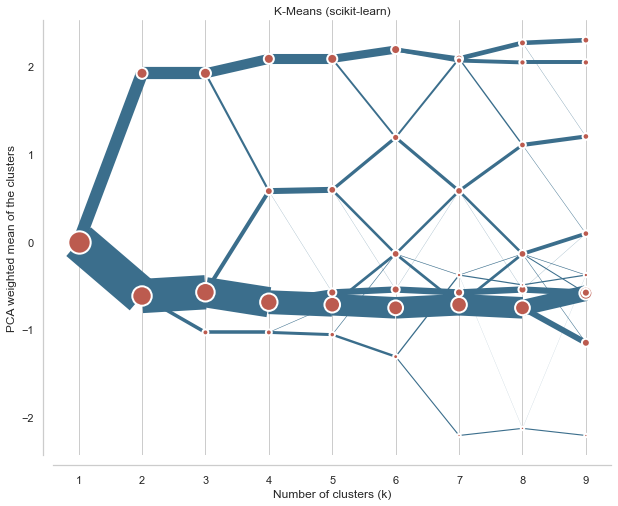

In [5]:
# from the clustergram project page 
data = scale(player_coords.drop(columns=['fullName']))

cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(data)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

## Analyzing the optimal number of clusters

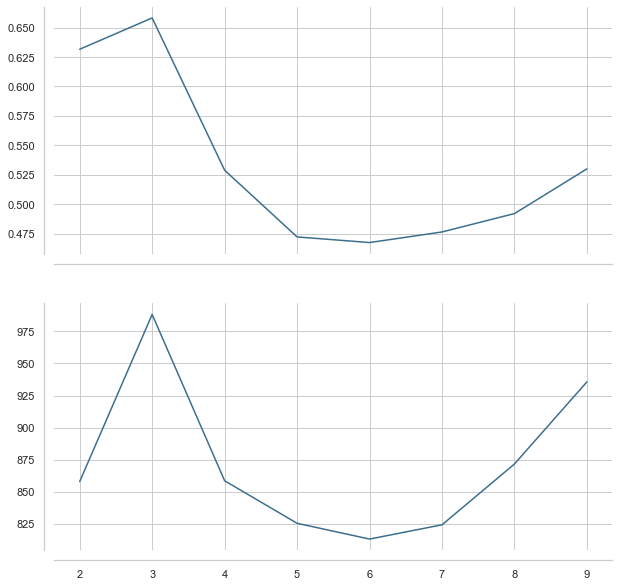

In [6]:
# also from the project page 
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
# score of 1 is best with the silhouette score
cgram.silhouette_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
# the higher the value, the better
cgram.calinski_harabasz_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

**3 clusters looks optimal**. Therefore, when we use a clustering algorithm (e.g.: Kmeans), we know the number of clusters for it to create.

# Cluster the data - Kmeans

In [7]:
# adjusting the data to be an array
X = np.array(player_coords[['Lat', 'Lng']])

In [8]:
# applying Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [9]:
# adding labels to player_gdf
player_gdf['player_cluster'] = kmeans.labels_

In [10]:
kmeans.cluster_centers_

array([[  44.952668  ,  -94.8177072 ],
       [  43.24011627,  -77.3498787 ],
       [  48.92488235, -117.14823277]])

# Plotting Data

<AxesSubplot:>

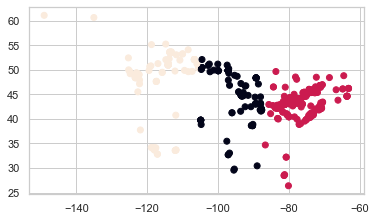

In [11]:
player_gdf.plot(column='player_cluster')

## Adding Centroids to the data

In [13]:
centroid_gdf = gpd.GeoDataFrame(data=[f"Cluster{x}" for x in range(0, 3)], columns = ['fullName'])

In [14]:
# making the centroids into points
centroid_gdf['geometry'] = [Point(coord[1], coord[0]) for coord in kmeans.cluster_centers_]
centroid_gdf['player_cluster'] = [x for x in range(4, 7)]

In [15]:
# cluster0's centroid is near Rochester, NY, USA
# cluster1's centroid is near the northern Washington/Idaho border, USA
# cluster2's centroid is west of Minneapolis, MN, USA
centroid_gdf

,fullName,geometry,player_cluster
0,Cluster0,POINT (-94.81771 44.95267),4
1,Cluster1,POINT (-77.34988 43.24012),5
2,Cluster2,POINT (-117.14823 48.92488),6


In [16]:
# merging the two
player_gdf_w_centroids = pd.concat([player_gdf, centroid_gdf])
# player_gdf.concat(centroid_gdf)

<AxesSubplot:>

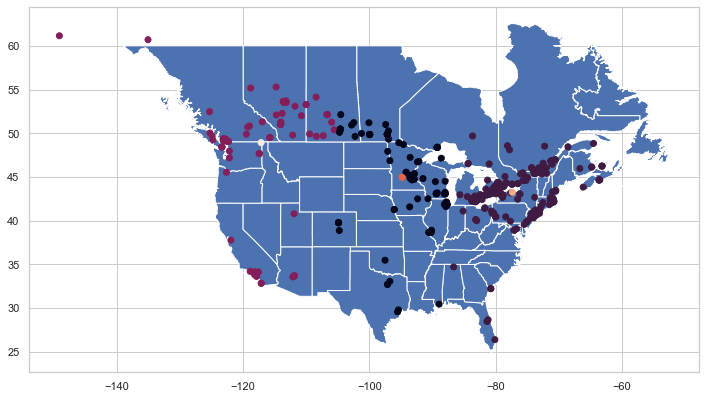

In [32]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
ax1 = us_can_gdf.plot(figsize = (12, 12))
player_gdf_w_centroids.plot(column='player_cluster', ax=ax1, figsize = (12, 12))
# plt.savefig("pictures/player_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

## How many players are in each cluster?

In [22]:
# clusters: 0 = east coast, 1 = west coast, 2 = central
# 2-3x more players in cluster 0 (east coast) than other clusters
player_gdf.player_cluster.value_counts()

1    338
0    125
2    119
Name: player_cluster, dtype: int64